<center><img src="https://is1-ssl.mzstatic.com/image/thumb/Purple122/v4/05/e7/67/05e76784-3364-b535-7e20-b3f4946a56b6/AppIcon-0-0-1x_U007emarketing-0-0-0-7-0-0-sRGB-0-0-0-GLES2_U002c0-512MB-85-220-0-0.png/434x0w.webp" style="height:150px"></center>

<hr style="border-width:2px;border-color:red">
<center><h1>Test Technique Data Scientist</h1></center>
<center><h2> Mesure de la dérive </h2></center>
<hr style="border-width:2px;border-color:red">

# Contexte

La **dérive** en apprentissage automatique (ou **"drift"** en anglais) fait référence à un **changement dans les données d'entrée ou de sortie d'un modèle** de machine learning **après son entraînement initial**. Cela peut se produire lorsque les données utilisées pour entraîner le modèle ne **reflètent plus la réalité**, ou lorsque **les conditions du problème changent de manière significative**.

La dérive des données peut affecter la précision du modèle de manière significative et peut entraîner des erreurs coûteuses dans les prévisions ou les décisions basées sur le modèle. Par conséquent, **il est important de surveiller régulièrement les performances du modèle** et de le mettre à jour en fonction des nouveaux jeux de données ou des nouvelles conditions du problème.

# Objectif

Dans ce test, vous allez implémenter des métriques permettant de mesurer la dérive d'un modèle dans un usecase de **e-commerce** où nous essayons de prédire le **panier total** (variable **`TotalCart`** : chiffre d'affaire total d'un client sur la période donnée) des clients en fonction des variables suivantes:
* **`Age`** : âge du client en années.
* **`Seniority`** : ancienneté du client en années.
* **`Orders`** : Nombre de commandes effectuées sur la période précédente.
* **`Items`** : Nombre d'items commandés sur la période précédente.
* **`AverageDiscount`** : Réduction moyenne accordée au client sur la période précédente en pourcentage.
* **`TopCategory`** : Catégorie de produits favorite du client.
* **`BrowsingTime`** : Temps total passé sur le site web sur la période précédente en secondes.
* **`EmailsOpened`** : Nombre de mails marketing ouverts par le client sur la période précédente.
* **`SupportInteractions`** : Nombre d'interactions que le client a eu avec le service client sur la période précédente.

Le jeu de données est décomposé en 4 périodes correspondant aux 4 trimestres de l'année 2022. Vous trouverez les données correspondant à chaque période dans les fichiers **`period_0.csv`**, **`period_1.csv`**, ..., **`period_3.csv`**.

Vous allez d'abord **entraîner et évaluer un modèle de machine learning** sur les données de la **période 0**. On supposera que ce modèle sera utilisé pour effectuer les prédictions de panier total sur toute l'année 2022.

Ensuite, vous devrez **implémenter des métriques de dérive** qui vous seront données et **effectuer une analyse** de celle-ci.

# Entraînement du modèle

* **Entraînez et validez** deux ou trois modèles de votre choix sur les données de la période 0. 

**Conseils**

* Vous serez évalué sur votre **rigueur** et non sur les performances du modèle.


* Il n'est pas nécessaire de faire une analyse exploratoire des données.


* Il n'est pas nécessaire de faire de recherche d'hyperparamètres optimaux non plus mais vous pouvez le faire si vous le souhaitez.

#### 1 - Chargement des données

In [20]:
import io
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

line = "="*50

Chargement des données depuis le dépôt github..

In [38]:
url = "https://raw.githubusercontent.com/fereol023/test_drift/main/datasets/period_"
data = dict()

# enregistrer toutes les données de bases dans un seul endroit indexé par le temps
for t in range(4):
    url2 = url + str(t) + ".csv"
    # print(url2)
    download = requests.get(url2).content
    data[t] = pd.read_csv(io.StringIO(download.decode()))

# aperçu
data[0].head()

,Age,Seniority,Orders,Items,AverageDiscount,TopCategory,BrowsingTime,EmailsOpened,SupportInteractions,TotalCart
0,21,2,4,7,0.14,"Clothing,Shoes & Jewelry",68.473629,3,2,34.00
1,22,0,4,5,0.50,Toys & Games,29.258063,1,0,28.28
2,22,1,2,6,0.37,"Health, Household & Baby Care",11.515517,0,0,19.33
3,19,0,2,8,0.60,Toys & Games,74.495861,1,0,26.83
4,25,1,1,5,0.58,Toys & Games,1.682705,2,1,17.67


Aperçu des types de variables et de leur description globale, la taille de données etc. utile pour savoir quelle approche adopter

In [23]:
df0 = data[0]
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1000 non-null   int64  
 1   Seniority            1000 non-null   int64  
 2   Orders               1000 non-null   int64  
 3   Items                1000 non-null   int64  
 4   AverageDiscount      1000 non-null   float64
 5   TopCategory          1000 non-null   object 
 6   BrowsingTime         1000 non-null   float64
 7   EmailsOpened         1000 non-null   int64  
 8   SupportInteractions  1000 non-null   int64  
 9   TotalCart            1000 non-null   float64
dtypes: float64(3), int64(6), object(1)
memory usage: 78.2+ KB


Nous pouvons voir que la variable *TopCategory* des variables est de type 'object'. Il faudra la recoder par la suite.<br><br>A part ça, toutes les variables semblent être prêtes : <br>*TotalCart* est de type 'float' continue de même que AverageDiscount et BrowsingTime. Les autres sont des variables categorielles ou de comptage. <br>Il n'y a pas de valeur manquante.<br><br>Observons ensuite quelques statistiques calculées sur ces variables pour avoir un aperçu des distributions.

In [24]:
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,24.069000,5.059430,7.000000,21.000000,24.000000,27.000000,41.000000
Seniority,1000.0,0.508000,0.720038,0.000000,0.000000,0.000000,1.000000,4.000000
Orders,1000.0,3.011000,1.731438,0.000000,2.000000,3.000000,4.000000,9.000000
Items,1000.0,5.975000,2.399194,1.000000,4.000000,6.000000,7.000000,15.000000
AverageDiscount,1000.0,0.371700,0.219133,0.000000,0.180000,0.380000,0.560000,0.750000
BrowsingTime,1000.0,97.949068,100.222845,0.012724,29.333357,68.037177,127.063901,831.026761
EmailsOpened,1000.0,0.989000,1.002938,0.000000,0.000000,1.000000,2.000000,5.000000
SupportInteractions,1000.0,1.012000,1.022204,0.000000,0.000000,1.000000,2.000000,7.000000
TotalCart,1000.0,35.884260,17.619171,0.000000,25.575000,33.655000,43.772500,138.880000


On cherche aussi à visualiser les liens entre les variables : linéaires ou quadradatique pour avoir des pistes sur le type de modélisation.

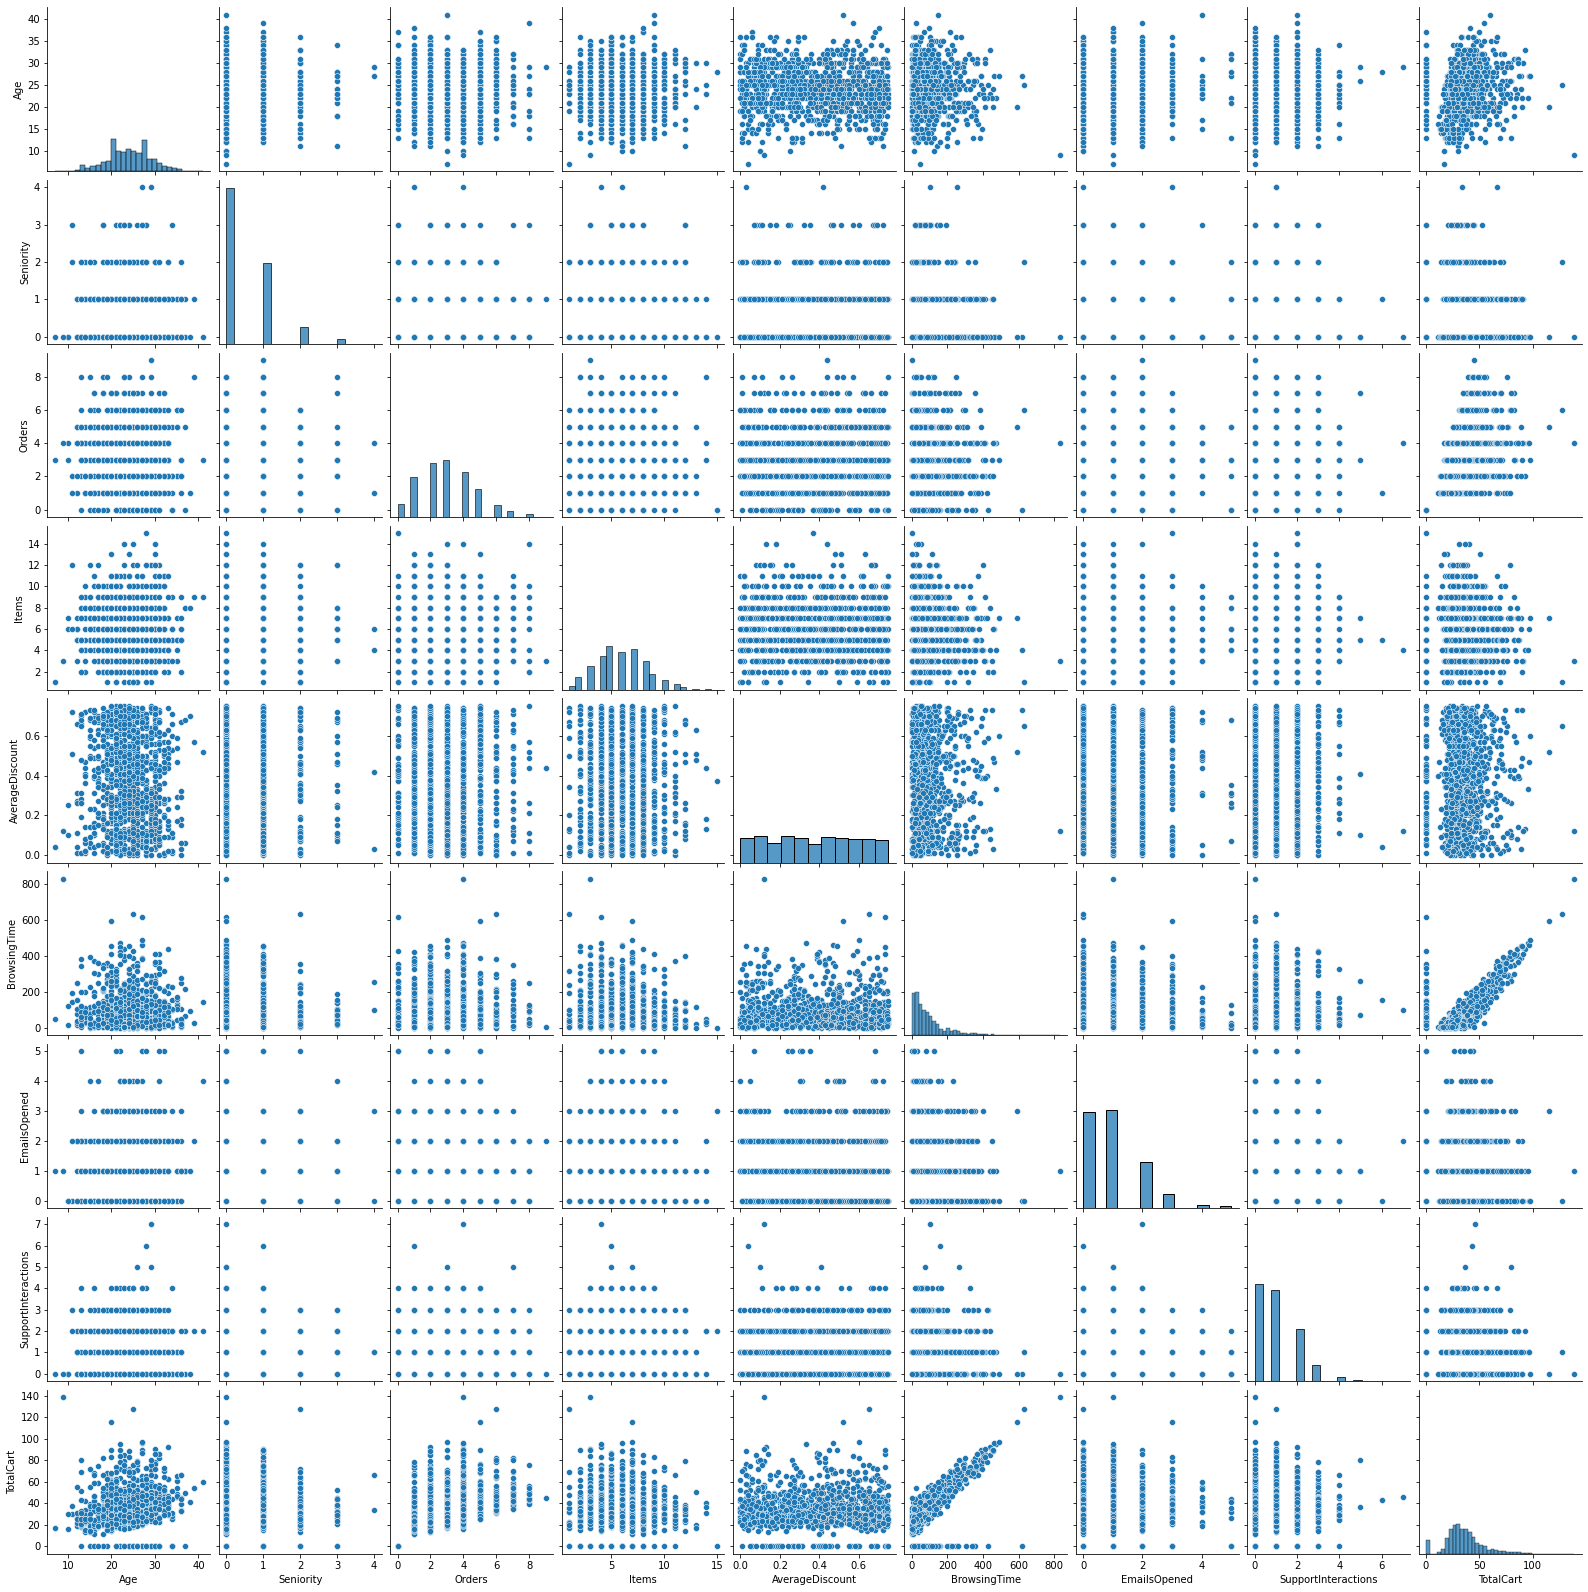

In [21]:
sns.pairplot(df0)

#### 2 - Preprocessing

In [17]:
df0.dtypes

Age                      int64
Seniority                int64
Orders                   int64
Items                    int64
AverageDiscount        float64
TopCategory             object
BrowsingTime           float64
EmailsOpened             int64
SupportInteractions      int64
TotalCart              float64
dtype: object

Nous encodons donc la variable *TopCategory* avec une fonction (pour la réplicabilité sur les autres datasets)

In [22]:
df0.select_dtypes(include="object").head()

,TopCategory
0,"Clothing,Shoes & Jewelry"
1,Toys & Games
2,"Health, Household & Baby Care"
3,Toys & Games
4,Toys & Games


In [25]:
def clean_df(df, col="TopCategory"):
    
    df[col] = LabelEncoder().fit_transform(df[col])
    return df

clean_df(df0).dtypes

Age                      int64
Seniority                int64
Orders                   int64
Items                    int64
AverageDiscount        float64
TopCategory              int32
BrowsingTime           float64
EmailsOpened             int64
SupportInteractions      int64
TotalCart              float64
dtype: object

#### 3 - Training

**Sélection de modèles**<br><br>
La variable a prédire est le CA total d'un client sur une période donnée. En raison de la nature quantitative et continue de cette variable et de ses prédicteurs, les modèles suivants sont les plus aptes à traduire le lien existant entre le CA et les autres variables observées : <br><br>

a - **Régression Linaire multiple** : <br>Car nous disposons de plusieurs prédicteurs et il ne semble pas y avoir de relation autre que linéaire entre les variables quantitatives du dataset (cf. matrice). <br><br>
b - **RandomForest** : <br><br>
c - **SVR** : <br><br>

Nous n'exploiterons pas la piste du SGD (descente de gradient) car à priori on peut dire qu'il y  trop peu  de données (1000 observations) pour que ce type de modèle converge bien. 

In [30]:
data[1].head()

,404: Not Found


In [44]:
# pour éviter de répeter partout au cas où le nom change
target = "TotalCart"

# Train sets
X_train = df0.drop(target, axis=1)
y_train = df[target]

# Test sets
# -- copies en mémoire pour ne pas abîmer les jdd originels
df1 = clean_df(data[1].copy())
df2 = clean_df(data[2].copy())
df3 = clean_df(data[3].copy())

# features
X_test1 = df1.drop(target, axis=1)
X_test2 = df2.drop(target, axis=1)
X_test3 = df3.drop(target, axis=1)
# targets
y_test1 = df1[target]
y_test2 = df2[target]
y_test3 = df3[target]

,Age,Seniority,Orders,Items,AverageDiscount,TopCategory,BrowsingTime,EmailsOpened,SupportInteractions
0,21,0,2,6,0.12,0,26.266632,0,2
1,24,1,4,6,0.80,4,29.423088,0,0
2,26,3,3,8,0.12,1,348.042881,2,2
3,20,0,4,5,0.78,4,396.084596,0,2
4,22,0,0,4,0.79,8,255.968997,3,3


In [40]:
# Modèle de reg lineaire multiple
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [42]:
# Modèle random forest 
seed = 2309
rf = RandomForestRegressor(random_state=seed)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=2309)

In [43]:
svr = SVR(kernel = 'rbf')
svr.fit(X_train, y_train)

SVR()

In [84]:
def evaluate_model(model, rep = False):
    
    train_preds = model.predict(X_train)
    rmse_train = round(mean_squared_error(y_train, train_preds, squared=False), 3)
    
    test_preds_1 = model.predict(X_test_1)
    rmse_test_1 = round(mean_squared_error(y_test_1, test_preds_1, squared=False), 3)
    
    test_preds_2 = model.predict(X_test_2)
    rmse_test_2 = round(mean_squared_error(y_test_2, test_preds_2, squared=False), 3)
    
    test_preds_3 = model.predict(X_test_3)
    rmse_test_3 = round(mean_squared_error(y_test_3, test_preds_3, squared=False), 3)

    if rep :
        return rmse_train, rmse_test_1, rmse_test_2, rmse_test_3 
    else : 
        print(line)
        print("Train set error :",rmse_train) 
        print("Period 1 set error :", rmse_test_1)
        print("Period 2 set error :", rmse_test_2)
        print("Period 3 set error :", rmse_test_3)

In [70]:
def evaluate_model(model, t=3, rep = False):
    
    # on enregistrera les performances à chaque période dans une liste
    res = list()
    # print(X_train.shape)
    train_preds = model.predict(X_train)
    rmse_train = round(mean_squared_error(y_train, train_preds, squared=False), 3)
    # le premier résultat est donc celui de la période 0
    res.append(rmse_train)
    
    for k in range(1, t+1) :
        X_test = clean_df(data[k].copy()).drop(target, axis=1)
        y_test = clean_df(data[k].copy())[target]
        # print(X_test.shape)
        test_preds = model.predict(X_test)
        rmse_test = round(mean_squared_error(y_test, test_preds, squared=False), 3)
        res.append(rmse_test)

    if rep :
        return res 
    else : 
        print(line)
        print("Train set error :",rmse_train)
        for k in range(1, t+1) :
            print("Period "+str(k)+" set error :", res[k])

In [71]:
# execution
print("Regression lineaire")
evaluate_model(lr)
print("\nRandom forest")
evaluate_model(rf)
print("\nSupport Vector Reg")
evaluate_model(svr)

Regression lineaire
Train set error : 8.006
Period 1 set error : 9.458
Period 2 set error : 10.473
Period 3 set error : 15.36

Random forest
Train set error : 0.948
Period 1 set error : 8.056
Period 2 set error : 8.872
Period 3 set error : 12.907

Support Vector Reg
Train set error : 12.053
Period 1 set error : 14.408
Period 2 set error : 16.91
Period 3 set error : 23.386


Le modèle *Random Forest* apprend mieux sur les données, il fait en moyenne moins d'erreur que les deux autres modèles lors de  la phase d'apprentissage. De même lors de la phase de test, le modèle RF surperforme le modèle RL. On gardera donc le RF pour la suite.   

# Mesure de la dérive de variables catégorielles.

Pour deux distributions de probabilités discrètes $P$ et $Q$, la **divergence de Kullback–Leibler** de $P$ par rapport à $Q$ est définie par:

$$D_\text{KL}(P \parallel Q) = \sum_{x\in\mathcal{X}} P(x) \log\left(\frac{P(x)}{Q(x)}\right)$$


On définit la **divergence de Jensen-Shannon** comme une version lisse et symétrique de la divergence de Kullback-Leiber donnée par la formule suivante:

$${\rm JSD}(P \parallel Q)= \frac{1}{2}D(P \parallel M)+\frac{1}{2}D(Q \parallel M)$$

où $M=\frac{1}{2}(P+Q)$

### Exemple de calcul de $D_\text{KL}(P \parallel Q)$ : 

Soient $P$ =`[0.2, 0.3, 0.5]` et $Q$ =`[0.2, 0.4, 0.4]` deux vecteurs définissant une loi de probabilité discrete. Alors : 

$$
\begin{equation}
\begin{split}
D_\text{KL}(P \parallel Q) & = P(0) \log\left(\frac{P(0)}{Q(0)}\right)
                             + P(1) \log\left(\frac{P(1)}{Q(1)}\right)
                             + P(2) \log\left(\frac{P(2)}{Q(2)}\right)\\ \\
                           & = 0.2 \log\left(\frac{0.2}{0.2}\right)
                             + 0.3 \log\left(\frac{0.3}{0.4}\right)
                             + 0.5 \log\left(\frac{0.5}{0.4}\right) \\ \\
                           & = 0.02526...
\end{split}
\end{equation}
$$

### Exercice

* Implémenter des fonctions nommées **`KLDivergence(P, Q)`** et **`JSDivergence(P, Q)`** permettant de calculer les métriques définies ci-dessus.

**Conseils**:
* Utiliser la librairie Numpy permettant de facilement effectuer des calculs d'algèbre linéaire.

In [80]:
o = 1e-10
print(0.5/o)

5000000000.0


In [129]:
import numpy as np 

P = np.array([0.2, 0.3, 0.5])
Q = np.array([0.2, 0.4, 0.4])
# Q = np.array([0, 0.4, 0.4])

def KLDivergence(P, Q):
    o = 1e-10
    # il faut que les distributions de probabilités ne comportent pas de 0 c'est à dire que les données soient bien spécifiées
    # ajouter une constance pour le problème de la division par 0
    # source : 
    # return np.sum(P * np.log((P+o)/(Q+o)))
    return np.sum(P * np.log(P/Q))
    

def JSDivergence(P, Q):
    M = (P + Q)/2
    a = KLDivergence(P, M)/2
    b = KLDivergence(P, M)/2
    return (a+b)/2

* Lancer la cellule suivante pour tester votre fonction.

In [82]:
print("K-L Divergence:", KLDivergence(P, Q)) # compris entre 0 et 1
print("J-S Divergence:", JSDivergence(P, Q))

K-L Divergence: 0.02526715392157057
J-S Divergence: 0.003217526940367855


# Mesure de la dérive de variables quantitatives.

Soit $P$ une mesure empirique d'échantillons $X_1, \ldots, X_n
$ et $Q$ une mesure empirique d'échantillons $Y_1, \ldots, Y_n$, on définit la **Distance de Wasserstein** d'ordre $p$ par la fonction suivante :

$$W_p(P, Q) = \left( \frac{1}{n}\sum_{i=1}^n \|X_{(i)} - Y_{(i)}\|^p \right)^{1/p}$$

où $X_{(1)}, \ldots, X_{(n)}$ et $Y_{(1)}, \ldots, Y_{(n)}$ sont les [**statistiques d'ordre**](https://en.wikipedia.org/wiki/Order_statistic#Notation_and_examples) des échantillons $X$ et $Y$ et $p$ un nombre entier positif.

### Exercice

* Implémenter une fonction nommée **`WassersteinDistance(X, Y, p)`** permettant de calculer cette métrique à l'ordre **`p`** à partir de **deux échantillons** **`X`** et **`Y`** que l'on supposera de même longueur.

**Conseils**:
* Vous pouvez trier les échantillons pour obtenir les statistiques d'ordre.

In [83]:
def WassersteinDistance(X, Y, p):
    
    n = len(X)
    # ordonner les distributions
    X_o, Y_o = np.sort(X), np.sort(Y) 
    
    # détail étapes
    D = X_o - Y_o 
    res = np.sum(np.abs(D)**p)
    res /= n
    res = res**(1/p)
    return res

* Lancer la cellule suivante pour tester votre fonction.

In [84]:
X = np.random.beta(2, 6, 100)

Y = np.random.beta(3, 6, 100)

WassersteinDistance(X, Y, 2)

0.07650377491100892

# Étude de la dérive du modèle.

* En vous appuyant sur les métriques définies précédemment, illustrez et analysez visuellement la **dérive des données** ainsi que **la dérive du modèle** sur les périodes **1 à 3**. 


* Commenter les visualisations et déterminer si le modèle doit être mis à jour ou si sa performance est toujours acceptable. 

**Conseils**:
* Vous serez évalué sur **la rigueur et le soin** que vous donnerez à votre analyse, et sur **vos capacités à synthéthiser votre étude**. Vous ne serez pas évalué sur vos conclusions.


* Vous pouvez normaliser les données par rapport aux **moyennes et variances que vous calculerez sur la période 0** pour que les distances de Wasserstein pour différentes variables soient facilement comparables.

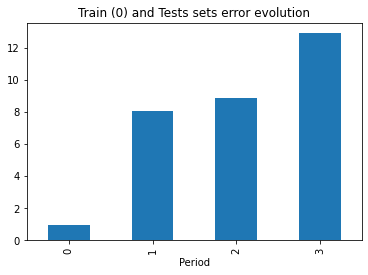

In [73]:
# constat de la derive du modèle
perfs = evaluate_model(rf, rep=True)
R = pd.Series(perfs).plot(kind='bar', title='Train (0) and Tests sets error evolution', xlabel='Period')

In [76]:
df.columns

Index(['Age', 'Seniority', 'Orders', 'Items', 'AverageDiscount', 'TopCategory',
       'BrowsingTime', 'EmailsOpened', 'SupportInteractions', 'TotalCart'],
      dtype='object')

* **TotalCart** : chiffre d'affaire total d'un client sur la période donnée) des clients
* **Age** : âge du client en années.
* **Seniority** : ancienneté du client en années.
* **Orders** : Nombre de commandes effectuées sur la période précédente.
* **Items** : Nombre d'items commandés sur la période précédente.
* **AverageDiscount** : Réduction moyenne accordée au client sur la période précédente en pourcentage.
* **TopCategory** : Catégorie de produits favorite du client.
* **BrowsingTime** : Temps total passé sur le site web sur la période précédente en secondes.
* **EmailsOpened** : Nombre de mails marketing ouverts par le client sur la période précédente.
* **SupportInteractions** : Nombre d'interactions que le client a eu avec le service client sur la période précédente.


#### Variables qualitatives

In [78]:
var_qual = ['TopCategory']

In [94]:
def all_JSD(var_qual, t):
    # on définit un dictionnaire pour enregistrer les divergences de toutes les variables qualitatives du dataset
    JSD = {}
    for var in var_qual :
        # on definit une liste pour récupérer les valeurs des divergences
        res = []
        # on prend la distribution de la période 0 comme référence
        P = clean_df(data[0])[var]
        for k in range (1, t+1) : 
            # à chaque période on récupère la distribution de la variable voulue
            Q = clean_df(data[k])[var]
            res.append(JSDivergence(P, Q))
        # on enregistre les divergences pour la variable
        JSD[var] = res
    return pd.DataFrame(JSD)

<AxesSubplot:title={'center':'Evolution de la divergence des variables qualitatives'}, xlabel='Period'>

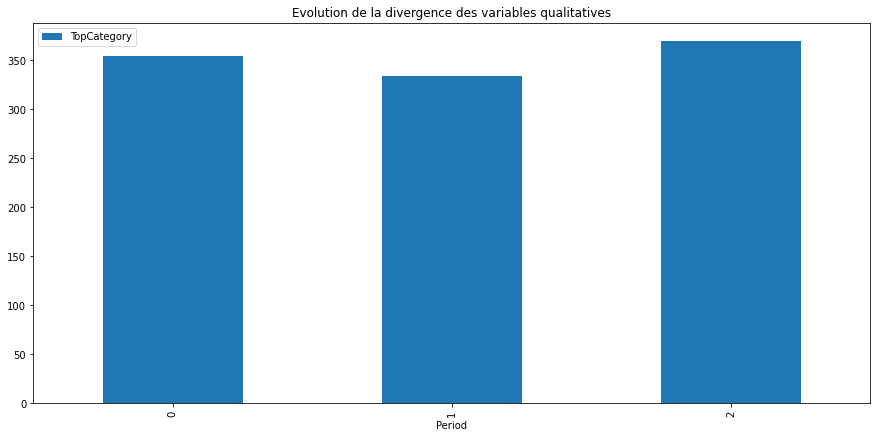

In [130]:
divs_quali = all_JSD(var_qual, t=3)
divs_quali.plot(kind='bar', title='Evolution de la divergence des variables qualitatives', xlabel='Period', figsize=(15,7))

In [131]:
zero div error

SyntaxError: invalid syntax (3295795510.py, line 1)

#### Variables quantitatives

In [116]:
var_quant = ['TotalCart', 'Age', 'Seniority', 'Orders', 'Items', 'AverageDiscount', 
         'BrowsingTime', 'EmailsOpened', 'SupportInteractions']

In [ ]:
WassersteinDistance(X, Y, 2)

In [121]:
def all_WDD(var_quant, t):
    # on définit un dictionnaire pour enregistrer les divergences de toutes les variables quantitatives du dataset
    WDD = {}
    
    for var in var_quant :
        # on definit une liste pour récupérer les valeurs des divergences
        res = []
        # on prend la distribution de la période 0 comme référence
        P = data[0][var].to_numpy().reshape(-1, 1)
        P = StandardScaler().fit_transform(P)
        for k in range (1, t+1) : 
            # à chaque période on récupère la distribution de la variable voulue
            Q = data[k][var].to_numpy().reshape(-1, 1)
            Q = StandardScaler().fit_transform(Q)
            res.append(WassersteinDistance(P, Q, 2))
        # on enregistre les divergences pour la variable
        WDD[var] = res
    return pd.DataFrame(WDD)

<AxesSubplot:title={'center':'Evolution de la divergence des variables quantitatives'}, xlabel='Period'>

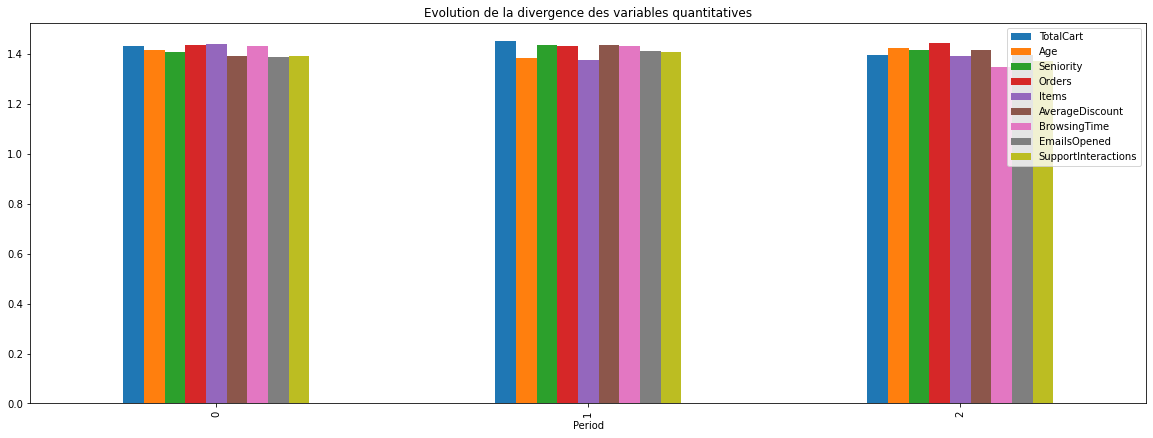

In [139]:
divs_quanti = all_WDD(var_quant, t=3)
divs_quanti.plot(kind='bar', title='Evolution de la divergence des variables quantitatives', 
                 xlabel='Period', figsize=(20,7))